In [1]:
import os
import tempfile
from glob import glob
from typing import Any, Callable, Dict, Optional

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from rasterio.crs import CRS
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchgeo.datasets import BoundingBox, stack_samples
from torchgeo.samplers import RandomGeoSampler
from torchgeo.samplers.batch import RandomBatchGeoSampler

/home/users/sofijas/miniconda3/envs/torchgeo_dev/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
os.chdir("/home/users/sofijas/WildfireDistribution/")
os.getcwd()

'/home/users/sofijas/WildfireDistribution'

In [4]:
from src.data_loading import MODIS_JD, LandcoverSimple, Sentinel2
from src.datamodules import MODISJDLandcoverSimpleDataModule

In [5]:
sentinel_test_dir = "/gws/nopw/j04/bas_climate/projects/WildfireDistribution/cloudless/2018"

In [17]:
datamodule = MODISJDLandcoverSimpleDataModule(
    modis_root_dir="data/modis/2018/",
    landcover_root_dir="data/landcover/",
    sentinel_root_dir=sentinel_test_dir,
    batch_size=5,
)

In [18]:
datamodule.setup()

In [19]:
ds = datamodule.dataset

In [25]:
sentinel = Sentinel2(
    sentinel_test_dir,
    ds.crs,
    ds.res,
    bands=["B03", "B08"],
)

In [14]:
ds_sent = ds & sentinel

In [26]:
print(sentinel)

Sentinel2 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=22.94431982933876, maxx=32.08198289940253, miny=50.77906806542419, maxy=53.044619211973625, mint=1514764799.999999, maxt=1551398399.999999)
    size: 1944


In [27]:
batch_sampler = RandomBatchGeoSampler(sentinel, size=256, batch_size=5, length=10, roi=ds.bounds)
dl = DataLoader(sentinel, batch_sampler=batch_sampler, collate_fn=stack_samples,)

In [29]:
for sample in dl:
    image = sample["image"]
    mask = sample["mask"]

IndexError: no such group

In [19]:
# image.shape, mask.shape

(torch.Size([5, 4, 256, 256]), torch.Size([5, 256, 256]))

In [22]:
train_dl = datamodule.train_dataloader()

In [23]:
for sample in train_dl:
    image = sample["image"]
    mask = sample["mask"]

IndexError: no such group

In [15]:
image.shape, mask.shape

(torch.Size([5, 1, 256, 256]), torch.Size([5, 256, 256]))

(-0.5, 255.5, 255.5, -0.5)

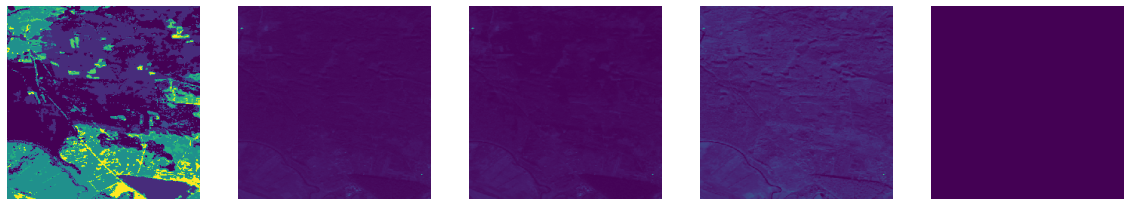

In [27]:
ncols = 5
nrows = 1

sample_n = 4

fig, axs = plt.subplots(
    nrows=1,
    ncols=ncols,
    figsize=(20, ncols * 6),
)

for i in range(ncols - 1):
    img = image[sample_n, i, :, :]
    img = torch.squeeze(img)
    axs[i].imshow(img)
    axs[i].axis("off")

msk = mask[sample_n, :, :]
msk = torch.squeeze(msk)
axs[4].imshow(msk)
axs[4].axis("off")